# 4. smearing

It's important to consider the effects of smearing in your scattering data based on the instrumental configuration. We are going to look at a similar spherical particle system as in the previous tutorial, but this time we will take into account a slit-smeared dataset with a beam length of 0.25 inverse Angstroms.

In [1]:
from bumps.names import Parameter, inf
from bumps.fitters import fit

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

import sasmodels
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment

import bumps

# uncomment and edit line below to add path to the sasview source code
# sys.path.append("/path/to/sasview/src")
import sas

Loading the `sphere_smearing.csv` data.

In [2]:
data_np = np.loadtxt('../example_data/sphere_smearing.csv',delimiter=',')
mask = np.where(data_np[:,1]>0)[0] # removing points that may be below zero due to noise
data = sasmodels.data.Data1D(x=data_np[mask,0], y=data_np[mask,1], dy=data_np[mask,2])

Setting up the `bumps` model with information about our system.

In [40]:
kernel = sasmodels.core.load_model("sphere")

scale = Parameter(0.5, name='scale').range(0,1) # setting our fitting range to (0,1)
background = Parameter(0.01, name='incoherent background').range(0,1)

# scattering length densities for our scattering particles and solvent
sld = Parameter(0.728, name='sld')
sld_solvent = Parameter(5.238, name='sld solvent')

radius = Parameter(150, limits=(0,inf), name='radius').range(0,5000)
radius_pd = Parameter(0.05, limits=(0,inf), name='radius')
radius_pd_type = 'lognormal'

model = Model(model=kernel,
             scale=scale,
             background=background,
             sld=sld,
             sld_solvent=sld_solvent,
             radius=radius,
             radius_pd=radius_pd,
             radius_pd_type=radius_pd_type
             )

As a comparison, let's first fit our data without smearing:

final chisq 139.1237(35)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                   incoherent background 0.105650(58)    0.1056500(49)  
                                  radius 174.005(85)     174.0046(72)   
                                   scale 0.14713(30)     0.147130(26)   


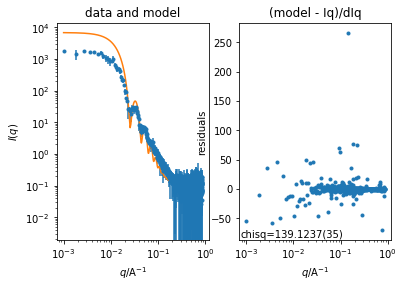

In [41]:
experiment = sasmodels.bumps_model.Experiment(data=data, model=model)
problem = bumps.fitproblem.FitProblem(experiment)
results = bumps.fitters.fit(problem, method='lm', verbose=True)
problem.plot()

Now let's setup our system again and this time add in the smearing contributions:

In [42]:
kernel = sasmodels.core.load_model("sphere")

scale = Parameter(0.5, name='scale').range(0,1) # setting our fitting range to (0,1)
background = Parameter(0.01, name='incoherent background').range(0,1)

# scattering length densities for our scattering particles and solvent
sld = Parameter(0.728, name='sld')
sld_solvent = Parameter(5.238, name='sld solvent')

radius = Parameter(150, limits=(0,inf), name='radius').range(0,5000)
radius_pd = Parameter(0.05, limits=(0,inf), name='radius')
radius_pd_type = 'lognormal'

model = Model(model=kernel,
             scale=scale,
             background=background,
             sld=sld,
             sld_solvent=sld_solvent,
             radius=radius,
             radius_pd=radius_pd,
             radius_pd_type=radius_pd_type
             )

To account for smearing, we need to add information about the configuration into the `bumps` Experiment.

In [43]:
experiment = sasmodels.bumps_model.Experiment(data=data, model=model)

smearing = sasmodels.resolution.Slit1D(data.x, 0.25)
experiment.resolution = smearing

final chisq 0.4434(35)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                   incoherent background 0.099965(59)    0.099965(89)   
                                  radius 167.02(21)      167.02(32)     
                                   scale 0.9982(20)      0.9982(30)     


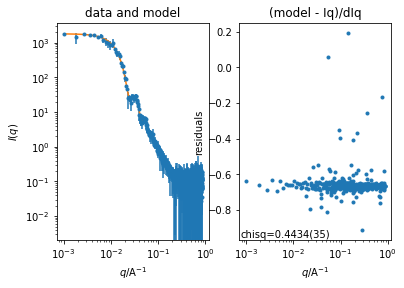

In [44]:
problem = bumps.fitproblem.FitProblem(experiment)
results = bumps.fitters.fit(problem, method='lm', verbose=True)
problem.plot()